# Does the linear regression make sense?

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import functions as f
import random

In [2]:
import scipy.stats as st

def get_pvalue(count, permut):
    # calculating p-value
    z_score = (np.array(count['matches'])-np.array(permut['mean']))/np.array(permut['std'])


    #cumulative distribution function
    # --> not sure if I should take 1- ? for righttailed test? yes. 
    p_values = st.norm.sf(z_score)


    # significance 5%
    top = st.norm.ppf(.975)
    bottom = st.norm.ppf(.025)
    
    return (p_values, z_score)

# PCA permutations

In [3]:
# import permutation scores
percentages = list(np.arange(0, 1.02, 0.02))
# acutally counts. of the evaluated permutations
pca_permut160 = pd.read_pickle('pca/permutations.pkl')

pca_count160 = pd.DataFrame(pd.read_pickle('pca/count.pkl'), columns = ['matches'])
pca_permut160['percentages'], pca_count160['percentages']=percentages, percentages

In [4]:
p_values, z_scores = get_pvalue(count = pca_count160, permut = pca_permut160)

<ipython-input-2-9ee0f4bf0da3>:5: RuntimeWarning: invalid value encountered in true_divide
  z_score = (np.array(count['matches'])-np.array(permut['mean']))/np.array(permut['std'])


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


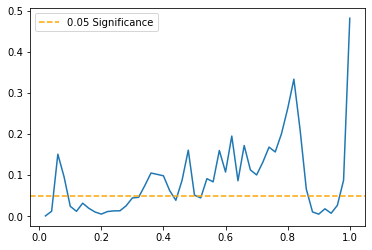

In [5]:
ax = sns.lineplot(percentages, p_values)
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()

In [7]:
pls_count160 = pd.DataFrame(pd.read_pickle('pls/count.pkl'), columns = ['matches'])
pls_count160['percentages']=percentages

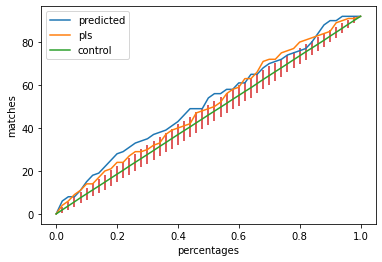

In [8]:
ax = sns.lineplot(data = pca_count160, x='percentages', y = 'matches',label='predicted')
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pca_permut160, x ='percentages', y = 'mean', label='control')
ax.errorbar(pca_permut160['percentages'], pca_permut160['mean'], yerr=pca_permut160['std'], fmt=' ', zorder=-1)
ax.legend()


#### There are 416 matches from the RegNet database for the 160 relevant genes, looking at predictors and targets. Of those, 91 are also represented in our set of 1109*152=167,459 pairs. 


# PLS - Permutations

In [9]:
# import permutation scores
percentages = list(np.arange(0, 1.02, 0.02))
# acutally counts. of the evaluated permutations
pls_permut160 = pd.read_pickle('pls/permutations.pkl')


pls_count160 = pd.DataFrame(pd.read_pickle('pls/count.pkl'), columns = ['matches'])
pls_permut160['percentages'], pls_count160['percentages']=percentages, percentages

In [10]:
z_scores

array([       nan, 3.12951595, 2.24813911, 1.03149803, 1.30326439,
       1.9727544 , 2.2546076 , 1.8537599 , 2.06790651, 2.31406778,
       2.55303066, 2.27258207, 2.22327589, 2.21485341, 1.94996552,
       1.69939149, 1.683089  , 1.44218892, 1.25194277, 1.27030779,
       1.2896556 , 1.53320623, 1.76282914, 1.35506842, 0.99072094,
       1.63239493, 1.69801334, 1.33157564, 1.37948603, 0.99348217,
       1.23882546, 0.85856095, 1.36287523, 0.94520695, 1.21139032,
       1.27810592, 1.11876957, 0.96064553, 1.00857896, 0.83867244,
       0.63728744, 0.42956472, 0.8038102 , 1.50447528, 2.30536682,
       2.561142  , 2.09309745, 2.43683054, 1.93354589, 1.35607651,
       0.04476615])

In [11]:
p_values, z_scores = get_pvalue(count = pls_count160, permut = pls_permut160)

<ipython-input-2-9ee0f4bf0da3>:5: RuntimeWarning: invalid value encountered in true_divide
  z_score = (np.array(count['matches'])-np.array(permut['mean']))/np.array(permut['std'])


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


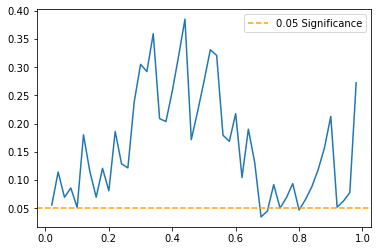

In [12]:
ax = sns.lineplot(percentages, p_values)
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()

Is this normal that it only goes to 0.5? 

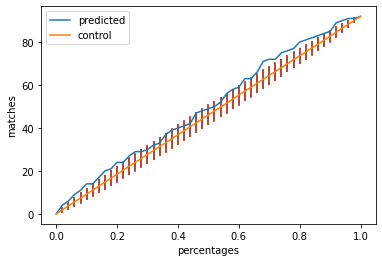

In [13]:
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='predicted')
ax = sns.lineplot(data = pls_permut160, x ='percentages', y = 'mean', label='control')
ax.errorbar(pca_permut160['percentages'], pca_permut160['mean'], yerr=pca_permut160['std'], fmt=' ', zorder=-1)
ax.errorbar(pls_permut160['percentages'], pls_permut160['mean'], yerr=pls_permut160['std'], fmt=' ', zorder=-1)
ax.legend()


# Linear - Permutations

In [14]:
# import permutation scores
percentages = list(np.arange(0, 1.02, 0.02))
# acutally counts. of the evaluated permutations
linear_permut160 = pd.read_pickle('linearQuick/permutations.pkl')


linear_count160 = pd.DataFrame(pd.read_pickle('linearQuick/count.pkl'), columns = ['matches'])
linear_permut160['percentages'], linear_count160['percentages']=percentages, percentages

In [15]:
p_values, z_scores = get_pvalue(count = linear_count160, permut = linear_permut160)

<ipython-input-2-9ee0f4bf0da3>:5: RuntimeWarning: invalid value encountered in true_divide
  z_score = (np.array(count['matches'])-np.array(permut['mean']))/np.array(permut['std'])


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


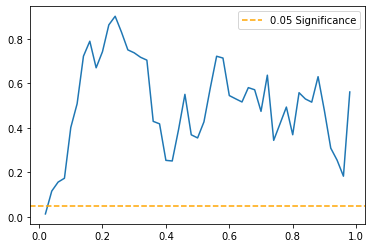

In [16]:
ax = sns.lineplot(percentages, p_values)
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()

Is this normal that it only goes to 0.5? 

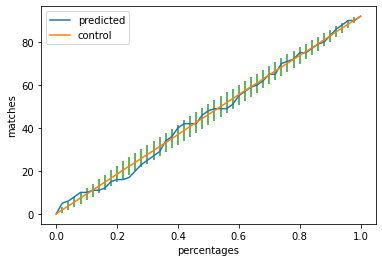

In [17]:
ax = sns.lineplot(data = linear_count160, x='percentages', y = 'matches',label='predicted')
ax = sns.lineplot(data = linear_permut160, x ='percentages', y = 'mean', label='control')
ax.errorbar(linear_permut160['percentages'], linear_permut160['mean'], yerr=linear_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
